#Import Libraries

In [ ]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from tabulate import tabulate      #For displaying results

#Exploratory Data Analysis (EDA)

In [ ]:
# Setting Directories for the dataset and subclasses
train_data_dir = 'dataset'     #Notice, you might need to change the directory based on where the dataset is.

#Male pictures
train_male_dir = os.path.join(train_data_dir, 'maleeyes')

#Female Pictures
train_female_dir = os.path.join(train_data_dir, 'femaleeyes')

#File names for the male and female eyes classes
train_male_fnames = os.listdir( train_male_dir )
train_female_fnames = os.listdir( train_female_dir )

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_male_pix = [os.path.join(train_male_dir, fname) 
                for fname in train_male_fnames[ pic_index-8:pic_index] 
               ]

next_female_pix = [os.path.join(train_female_dir, fname) 
                for fname in train_female_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_male_pix+next_female_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

#Benchmark Classifier
##Support Vector Machine (SVM)
###Data Preprocessing for SVM

In [ ]:
#Class Categories
Categories=['maleeyes','femaleeyes']

#input array
flat_data_arr=[] 
#output array
target_arr=[] 

#path which contains all the categories of images
for i in Categories:
    
    print(f'loading... category : {i}')
    path=os.path.join(train_data_dir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(60,60,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
    
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)

#dataframe
df=pd.DataFrame(flat_data) 
df['Target']=target

#features
x=df.iloc[:,:-1]  
#labels
y=df.iloc[:,-1] 

#Data Splitting into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)

print('Splitted Successfully')

loading... category : maleeyes
loaded category:maleeyes successfully
loading... category : femaleeyes
loaded category:femaleeyes successfully
Splitted Successfully


###SVM Classifier

In [ ]:
#Define SVM model with Radial Bases Kernel            
svm_model = svm.SVC(kernel='rbf')

#Model Training  
svm_model.fit(x_train,y_train)

#Model Prediction
svm_pred = svm_model.predict(x_test)


#SVM Accuracy
svm_acc = accuracy_score(y_test, svm_pred)

#Classification Details
print('Support Vector Machine Model Classification Report\n')
print(classification_report(y_test, svm_pred, target_names=[l for l in Categories]))

Support Vector Machine Model Classification Report

              precision    recall  f1-score   support

    maleeyes       0.89      0.94      0.91      1265
  femaleeyes       0.92      0.86      0.89      1040

    accuracy                           0.90      2305
   macro avg       0.91      0.90      0.90      2305
weighted avg       0.90      0.90      0.90      2305



#Deep Learning Classifiers
##Preprocessing Dataset

In [ ]:
#Input image dimensions
img_height = 60
img_width = 60

#Batch Size
batch_size = 20

#Number of epochs
epochs = 15
epochs_range   = range(epochs) # Get number of epochs

#Dataset Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,  #Normalizing the dataset
    validation_split=0.2) # set validation split

#Training Dataset
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

#Validation Dataset
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 9221 images belonging to 2 classes.
Found 2304 images belonging to 2 classes.


###Multilayer Perceptron and Convolutional Neural Network
####Model Creation
As required in the instruction, two deep learning models are required. First one is a Multilayer Perceptron (MLP) and the second one is Convolutional Neural Network (CNN). The model architecture for the MLP is designed such that first the input image is flattened to a 1D array since the model can not accept a multidimensional array (since an image is a 3D array first two for height and width and last for color channel). After flattening the input, in total 4 layers are defined. In the first layer there are 16 neurons and they are doubled in the subsequent layers. A last layer is defined with a single neuron since its a binary classification problem. For the activation functions, in the first 3 layers (ignoring the flattening) the activation function is set to be relu and in the last layer sigmoid activation is applied in order to convert the output to probabilities for each class. 
For the CNN model there are 3 convolutional layers and 3 pooling layers followed by a single dense layer having 64 neurons. The filter size is kept to be 3 by 3 and the pooling to be 2 by 2. 16, 32 and 64 filters are used respectively in each layer. The filters help to extract key features from the images which are then utilized by the dense layer and finally classified.

In [ ]:
#Multilayer Perceptron Model
mlp_model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 60x60 with 3 bytes color
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('female') and 1 for the other ('male')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


#CNN Model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

####Multilayer Perceptron model training

In [ ]:
#Model Compilation
mlp_model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

#Model Training
mlp_history = mlp_model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=train_generator.samples // batch_size,
                              epochs=epochs,
                              validation_steps=validation_generator.samples // batch_size,
                              verbose=2)

#Model Performance Evaluation
mlp_performance = mlp_model.evaluate(validation_generator)

Epoch 1/15
461/461 - 9s - loss: 0.9441 - accuracy: 0.5340 - val_loss: 0.6887 - val_accuracy: 0.5478 - 9s/epoch - 20ms/step
Epoch 2/15
461/461 - 8s - loss: 0.6909 - accuracy: 0.5466 - val_loss: 0.6889 - val_accuracy: 0.5478 - 8s/epoch - 17ms/step
Epoch 3/15
461/461 - 8s - loss: 0.6888 - accuracy: 0.5487 - val_loss: 0.6886 - val_accuracy: 0.5487 - 8s/epoch - 17ms/step
Epoch 4/15
461/461 - 9s - loss: 0.6887 - accuracy: 0.5489 - val_loss: 0.6884 - val_accuracy: 0.5487 - 9s/epoch - 20ms/step
Epoch 5/15
461/461 - 8s - loss: 0.6888 - accuracy: 0.5486 - val_loss: 0.6886 - val_accuracy: 0.5491 - 8s/epoch - 17ms/step
Epoch 6/15
461/461 - 8s - loss: 0.6887 - accuracy: 0.5483 - val_loss: 0.6893 - val_accuracy: 0.5478 - 8s/epoch - 17ms/step
Epoch 7/15
461/461 - 8s - loss: 0.6887 - accuracy: 0.5489 - val_loss: 0.6886 - val_accuracy: 0.5483 - 8s/epoch - 17ms/step
Epoch 8/15
461/461 - 9s - loss: 0.6887 - accuracy: 0.5485 - val_loss: 0.6885 - val_accuracy: 0.5487 - 9s/epoch - 20ms/step
Epoch 9/15
461/4

Loss of the MLP model is:  0.6895871758460999
Accuracy of the MLP model is:  0.5486111044883728


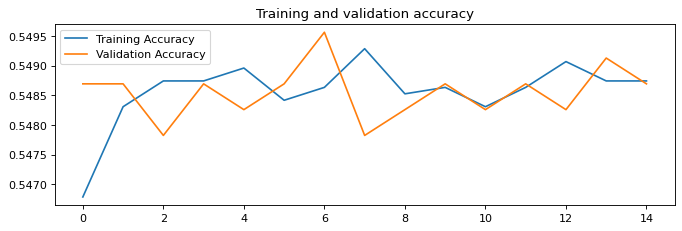

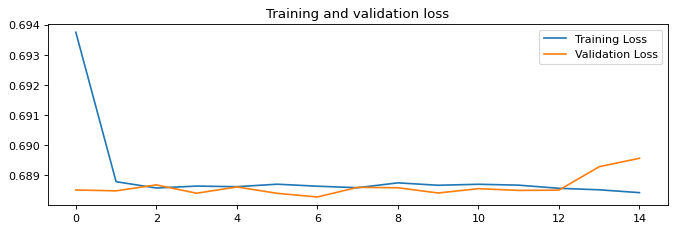

In [ ]:
#Plotting Model Accuracy and Loss vs Number of Epochs

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mlp_acc      = mlp_history.history[  'accuracy' ]
mlp_val_acc  = mlp_history.history[ 'val_accuracy' ]
mlp_loss     = mlp_history.history[    'loss' ]
mlp_val_loss = mlp_history.history['val_loss' ]


#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(10,3), dpi=80)
plt.plot  ( epochs_range,     mlp_acc )
plt.plot  ( epochs_range, mlp_val_acc )
plt.title ('Training and validation accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10,3), dpi=80)
plt.plot  ( epochs_range,     mlp_loss )
plt.plot  ( epochs_range, mlp_val_loss )
plt.title ('Training and validation loss')
plt.legend(['Training Loss', 'Validation Loss'])

print('Loss of the MLP model is: ', mlp_performance[0])
print('Accuracy of the MLP model is: ', mlp_performance[1])

In [ ]:
#Model Compilation
cnn_model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

#Model Training
cnn_history = cnn_model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=train_generator.samples // batch_size,
                              epochs=epochs,
                              validation_steps=validation_generator.samples // batch_size,
                              verbose=2)

#CNN Model Performance Evaluation
cnn_performance = cnn_model.evaluate(validation_generator)

Epoch 1/15
461/461 - 16s - loss: 0.4612 - accuracy: 0.7782 - val_loss: 0.4935 - val_accuracy: 0.7861 - 16s/epoch - 35ms/step
Epoch 2/15
461/461 - 9s - loss: 0.3095 - accuracy: 0.8721 - val_loss: 0.2435 - val_accuracy: 0.9009 - 9s/epoch - 19ms/step
Epoch 3/15
461/461 - 8s - loss: 0.2692 - accuracy: 0.8907 - val_loss: 0.2148 - val_accuracy: 0.9143 - 8s/epoch - 17ms/step
Epoch 4/15
461/461 - 8s - loss: 0.2357 - accuracy: 0.9053 - val_loss: 0.2231 - val_accuracy: 0.9096 - 8s/epoch - 17ms/step
Epoch 5/15
461/461 - 9s - loss: 0.2073 - accuracy: 0.9181 - val_loss: 0.2147 - val_accuracy: 0.9091 - 9s/epoch - 19ms/step
Epoch 6/15
461/461 - 8s - loss: 0.1929 - accuracy: 0.9226 - val_loss: 0.2727 - val_accuracy: 0.8904 - 8s/epoch - 16ms/step
Epoch 7/15
461/461 - 8s - loss: 0.1802 - accuracy: 0.9281 - val_loss: 0.1881 - val_accuracy: 0.9243 - 8s/epoch - 17ms/step
Epoch 8/15
461/461 - 9s - loss: 0.1585 - accuracy: 0.9369 - val_loss: 0.1826 - val_accuracy: 0.9300 - 9s/epoch - 19ms/step
Epoch 9/15
461

Loss of the CNN model is:  0.22830908000469208
Accuracy of the CNN model is:  0.9279513955116272


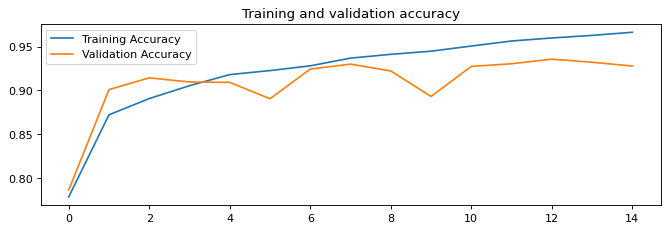

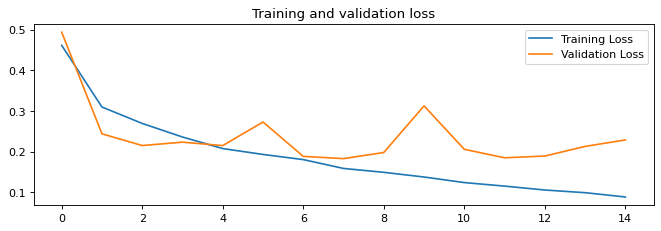

In [ ]:
#Plotting Model Accuracy and Loss function
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
cnn_acc      = cnn_history.history[  'accuracy' ]
cnn_val_acc  = cnn_history.history[ 'val_accuracy' ]
cnn_loss     = cnn_history.history[    'loss' ]
cnn_val_loss = cnn_history.history['val_loss' ]


#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(10,3), dpi=80)
plt.plot  ( epochs_range,     cnn_acc )
plt.plot  ( epochs_range, cnn_val_acc )
plt.title ('Training and validation accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10,3), dpi=80)
plt.plot  ( epochs_range,     cnn_loss )
plt.plot  ( epochs_range, cnn_val_loss )
plt.title ('Training and validation loss')
plt.legend(['Training Loss', 'Validation Loss'])

print('Loss of the CNN model is: ', cnn_performance[0])
print('Accuracy of the CNN model is: ', cnn_performance[1])

#Performance Comparison

In [ ]:
table = [['Model', 'Accuracy Score'], ['Support Vector Machine', str(svm_acc)], ['Multilayer Perceptron', str(mlp_performance[1])], ['Convolutional Neural Network', str(cnn_performance[1])]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+------------------------------+------------------+
| Model                        |   Accuracy Score |
+==============================+==================+
| Support Vector Machine       |         0.903688 |
+------------------------------+------------------+
| Multilayer Perceptron        |         0.548611 |
+------------------------------+------------------+
| Convolutional Neural Network |         0.927951 |
+------------------------------+------------------+


#Conclusion
In this notebook, the task of gender recognition from images of the eyes is performed. For that purpose, three classifiers were utilized. For benchmark, the first classifier is the SVM classifier, second one is a deep MLP and third one is a CNN model. SVM has traditionally been used extensively for classification tasks and have performed to be one of the best classifiers when there is not sufficient training data. The accuracy of the SVM classifier turned out to be 90 which is exceptionally well. The second model which is MLP performed really poorly as expected. Since the MLP simple dense layers are not good in capturing the features in an image that is why it did not perform well on our dataset. The third model which is a cnn model performed exceptionally well and topped the list in terms of accuracy score which is 92%. CNN's have turned out to be very effective when it comes to images and capturing the hidden features and the work presented in this book demonstrated the same.